**READ ME**

====

requires libtlda and fancyimpute

run "pip install fancyimpute libtlda --user" in a jupyter terminal

====

Requires: "training.csv", "additional_training.csv", "annotation_confidence.csv", "testing.csv" to be in the same directory as this notebook (.ipynb) file. 

====

Some cells take a lot of time to run (the 2d gridsearch takes 3 hours on my machine) and some take resources that i've not included (loading a pre-imputed CSV, instead of calculating it every time). So choose which cells to run!


In [39]:
#IMPORTS
import numpy as np
import pandas as pd
from sklearn import svm
from sklearn.model_selection import GridSearchCV, learning_curve
from sklearn.preprocessing import StandardScaler
from sklearn.impute import SimpleImputer
from sklearn.pipeline import Pipeline
import matplotlib.pyplot as plt
from matplotlib.colors import Normalize
from libtlda.iw import ImportanceWeightedClassifier
from sklearn.utils.class_weight import compute_class_weight
from fancyimpute import KNN, NuclearNormMinimization, SoftImpute, IterativeImputer, BiScaler
from sklearn.metrics import accuracy_score, make_scorer
from sklearn.decomposition import PCA

In [40]:
#LOAD ALL DATA
complete_dataset = pd.read_csv("training.csv", index_col = 0) #Data has all values filled in
incomplete_dataset = pd.read_csv("additional_training.csv", index_col = 0) #Data is missing values
unlabeled_dataset = pd.read_csv("testing.csv", index_col=0)
test_proportions = {0:0.6767, 1:0.3233}
dataset = complete_dataset.append(incomplete_dataset)
annotation_confidence = pd.read_csv("annotation_confidence.csv", index_col=0)

In [3]:
#GET TRAIN X, TRAIN Y, TEST X (Z)
X = dataset.drop("prediction", axis=1)
y = dataset[["prediction"]].squeeze()
Z = unlabeled_dataset

In [ ]:
#TEST IMPUTE METHODS TAKES 40 MINUTES
#make an fake incomplete data set from the original 259 data
W = np.array(complete_dataset)
missing_mask = np.random.choice([1, 0], W.shape, p=[.35, .65]).astype(bool)
W_incomplete = np.copy(W)
W_incomplete[missing_mask] = np.nan

#soft impute requires scaling
W_incomplete_normalized = BiScaler().fit_transform(W_incomplete)

#impute our fake incomplete data
%time W_filled_ii = IterativeImputer().fit_transform(W_incomplete)
%time W_filled_softimpute = SoftImpute().fit_transform(W_incomplete_normalized)
%time W_filled_knn = KNN(k=5).fit_transform(W_incomplete)
%time W_filled_simple = SimpleImputer().fit_transform(W_incomplete)

#print MSE to real values
print("IterativeImpute MSE: %f" % ((W_filled_ii[missing_mask] - W[missing_mask]) ** 2).mean())
print("SoftImpute MSE: %f" % ((W_filled_softimpute[missing_mask] - W[missing_mask]) ** 2).mean())
print("KnnImpute MSE: %f" % ((W_filled_knn[missing_mask] - W[missing_mask]) ** 2).mean())
print("SimpleImpute MSE: %f" % ((W_filled_simple[missing_mask] - W[missing_mask]) ** 2).mean())

In [4]:
#LOAD PREDONE IMPUTE X 
X_imputed = pd.read_csv("X_imputed.csv", index_col=0)

In [5]:
#IMPUTE X TAKES 7 MINUTES
X_imputed = KNN(k=5).fit_transform(X)
X_imputed = pd.DataFrame(X_imputed)
X_imputed.index += 1
X_imputed.to_csv("X_imputed.csv")

Imputing row 1/2590 with 0 missing, elapsed time: 334.594
Imputing row 101/2590 with 0 missing, elapsed time: 334.597
Imputing row 201/2590 with 0 missing, elapsed time: 334.600
Imputing row 301/2590 with 921 missing, elapsed time: 335.965
Imputing row 401/2590 with 863 missing, elapsed time: 339.201
Imputing row 501/2590 with 919 missing, elapsed time: 342.405
Imputing row 601/2590 with 984 missing, elapsed time: 345.606
Imputing row 701/2590 with 930 missing, elapsed time: 348.802
Imputing row 801/2590 with 913 missing, elapsed time: 352.002
Imputing row 901/2590 with 858 missing, elapsed time: 355.222
Imputing row 1001/2590 with 916 missing, elapsed time: 358.401
Imputing row 1101/2590 with 935 missing, elapsed time: 361.607
Imputing row 1201/2590 with 960 missing, elapsed time: 364.810
Imputing row 1301/2590 with 910 missing, elapsed time: 368.052
Imputing row 1401/2590 with 930 missing, elapsed time: 371.302
Imputing row 1501/2590 with 875 missing, elapsed time: 374.506
Imputing r

In [6]:
#SHOW CLASS/CONFIDENCE DISTRIBUTION
conf_dist = pd.concat([y, annotation_confidence], axis=1).groupby(["prediction", "confidence"]).size()
conf_dist

prediction  confidence
0           0.66           465
            1.00           570
1           0.66          1105
            1.00           450
dtype: int64

In [7]:
#DROP SAMPLES UNTIL CLASS/CONFIDENCE BALANCE

w = np.array(conf_dist)
#work out how many to remove from each class/conf
num_remove = {0:{0.66:w[0]-w[3], 1.0:w[1]-w[3]}, 1:{0.66:w[2]-w[3], 1.0:w[3]-w[3]}}
#add remove candidates to list
to_drop=[]
for i,label in enumerate(y):
    if i >= len(complete_dataset):
        conf = float(annotation_confidence.iloc[i])
        if num_remove[label][conf] > 0:
            to_drop.append(i+1)
            num_remove[label][conf]-=1

#remove the candidates and fix up the dataframes
X_imputed = X_imputed.drop(to_drop, axis=0).reset_index(drop=True)
X = X.drop(to_drop, axis=0).reset_index(drop=True)
annotation_confidence = annotation_confidence.drop(to_drop, axis=0).reset_index(drop=True)
y = y.drop(to_drop).reset_index(drop=True)
#redraw the conf/class table
pd.concat([y, annotation_confidence], axis=1).groupby(["prediction", "confidence"]).size()

prediction  confidence
0           0.66          450
            1.00          450
1           0.66          450
            1.00          450
dtype: int64

In [8]:
#CALCULATE SAMPLE WEIGHTS

#work out domain importance
domain_importance = ImportanceWeightedClassifier().iwe_kernel_mean_matching(X_imputed, Z)

#Domain + artificial class balance, this is used to score
score_weights = [domain_importance[i]  * test_proportions[int(y.iloc[i])] for i in range(len(y))]

#Domain + artificial class balance + confidence annotations, this is used to fit
fit_weights = [r * annotation_confidence.iloc[i] for i,r in enumerate(score_weights)]

#make into nice dataframes
score_weights = pd.DataFrame(score_weights).squeeze()
fit_weights = pd.DataFrame(fit_weights).squeeze()

     pcost       dcost       gap    pres   dres
 0:  9.0074e+02 -7.7392e+04  8e+04  0e+00  2e+03
 1:  8.8784e+02 -7.2042e+03  8e+03  3e-16  2e+02
 2:  8.6417e+02  4.9430e+02  4e+02  3e-18  4e-14
 3:  8.5995e+02  8.5595e+02  4e+00  3e-16  1e-14
 4:  8.5967e+02  8.5963e+02  4e-02  1e-16  5e-14
 5:  8.5966e+02  8.5966e+02  4e-04  3e-16  6e-14
Optimal solution found.


In [9]:
#CLASSIFIER
clf = Pipeline([
                ('scale', StandardScaler()),    #first scale mean=0, var=1
                ('pca', PCA(n_components = 200)), #then combine all features into 200 new features
                ('svm', svm.SVC(kernel="rbf", max_iter=10000)) #then feed those samples with 200 features into svm
                ])

In [21]:
#USE PRE-FOUND PARAMS
param_grid = {
                "svm__C": [2.0433597178569416],
                "svm__gamma": [0.000221221629107045]
             }

In [10]:
#2D PARAM SEARCH - TAKES 3 HOURS
C_range = np.logspace(-1,1,30)
gamma_range = np.logspace(-5,-2,30)
param_grid = {
                "svm__C": C_range,
                "svm__gamma": gamma_range
             }

In [11]:
#1D PARAM SEARCH
param_grid = {
                "svm__C": np.linspace(1,3,300),
                "svm__gamma": ["scale"]
             }

In [11]:
#SAMPLE-WEIGHTED SCORER
def weighted_accuracy_scorer(y_true, y_pred):
    return accuracy_score(y_true, y_pred, sample_weight=score_weights.loc[y_true.index.values])

#RUN GRIDSEARCH AND PRINT RESULTS
gridsearch = GridSearchCV(clf, param_grid, scoring=make_scorer(weighted_accuracy_scorer), cv=10, n_jobs=-1)
%time gridsearch.fit(X_imputed, y, svm__sample_weight=fit_weights)
print(gridsearch.best_params_)
print("cross-val score:" + str(gridsearch.best_score_))

Wall time: 2h 39min 27s
{'svm__C': 2.0433597178569416, 'svm__gamma': 0.000221221629107045}
cross-val score:0.7489742484904386


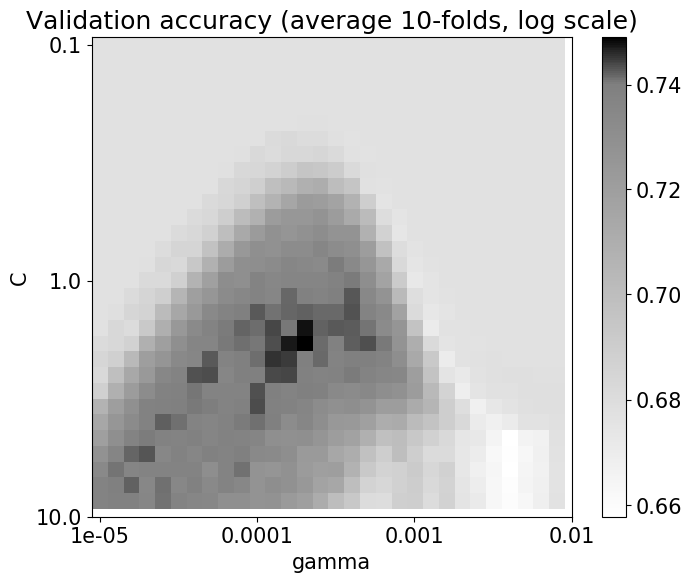

In [38]:
#DRAW 2D GRIDSEARCH RESULTS
#code modified from sklearn example "RBF SVM Parameters"


class MidpointNormalize(Normalize):

    def __init__(self, vmin=None, vmax=None, midpoint=None, clip=False):
        self.midpoint = midpoint
        Normalize.__init__(self, vmin, vmax, clip)

    def __call__(self, value, clip=None):
        x, y = [self.vmin, self.midpoint, self.vmax], [0, 0.5, 1]
        return np.ma.masked_array(np.interp(value, x, y))

scores = gridsearch.cv_results_['mean_test_score'].reshape(len(C_range),
                                                     len(gamma_range))
plt.figure(figsize=(8, 6))
plt.subplots_adjust(left=.2, right=0.95, bottom=0.15, top=0.95)
plt.imshow(scores, interpolation='nearest', cmap=plt.cm.gray_r,
           norm=MidpointNormalize(vmin=scores.min(), midpoint=0.74))
plt.xlabel('gamma')
plt.ylabel('C')
plt.colorbar()
plt.xticks( [30/3 * i for i in np.arange(0,4)],[10.0**i for i in np.arange(-5,-1)])
plt.yticks( [30/2 * i for i in np.arange(0,3)],[10.0**i for i in np.arange(-1,2)])
plt.title('Validation accuracy (average 10-folds, log scale)')
plt.rcParams.update({'font.size': 13})
plt.savefig('gridsearch.png')
plt.show()

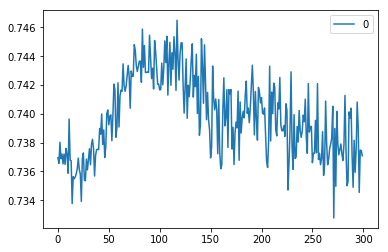

In [23]:
#1D GRIDSEARCH RESULTS 0:C=1 300:C=3
pd.DataFrame(gridsearch.cv_results_['mean_test_score']).plot()

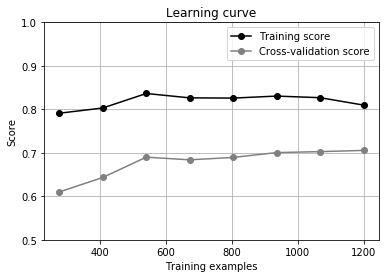

In [32]:
#DRAW LEARNING CURVE
#code modified from sklearn example "Learning curve"
plt.figure()
plt.title("Learning curve")
plt.ylim(*(0.5, 1))
plt.xlabel("Training examples")
plt.ylabel("Score")
train_sizes, train_scores, test_scores = learning_curve(
    gridsearch.best_estimator_, X_imputed, y, cv=3, n_jobs=-1, train_sizes=np.linspace(.23, 1.0, 8))
plt.plot(train_sizes, np.mean(train_scores, axis=1), 'o-', color="black",
         label="Training score")
plt.plot(train_sizes, np.mean(test_scores, axis=1), 'o-', color="grey",
         label="Cross-validation score")
plt.grid()
plt.legend(loc="best")
plt.savefig('learning.png')
plt.show()

In [14]:
#OUTPUT PREDICTIONS TO CSV IN ROOT DIRECTORY
predictions = pd.DataFrame(gridsearch.predict(Z).astype(int),columns=["prediction"])
predictions.index = predictions.index + 1
predictions.index.names = ['ID']
predictions.to_csv("prediction.csv")